In [10]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

In [2]:
class SGDRegressor:
    def __init__(self, D, learning_rate):
        self.lr = learning_rate
        
        self.W = tf.Variable(tf.random_normal(shape=(D,1), name='W'))
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.y = tf.placeholder(tf.float32, shape=(None,), name='y')
        
        y_pred = tf.reshape(tf.matmul(self.X, self.W), [-1])
        error = self.y - y_pred
        cost = tf.reduce_sum(error**2)
        
        self.train_op = tf.train.GradientDescentOptimizer(self.lr).minimize(cost)
        self.predict_op = y_pred
        
        init = tf.global_variables_initializer()
        self.session = tf.InteractiveSession()
        self.session.run(init)
        
    def partial_fit(self, X, y):
        self.session.run(self.train_op, feed_dict={self.X: X, self.y: y})
        
    def predict(self, X):
        return self.session.run(self.predict_op, feed_dict={self.X: X})

In [3]:
class FeatureTransformer:
    def __init__(self, env):
        obs_examples = np.random.random((20000, 4))*2-2
        scaler = StandardScaler()
        scaler.fit(obs_examples)
        
        featurizer = FeatureUnion([('rbf1', RBFSampler(gamma=0.05, n_components=1000)),
                                   ('rbf2', RBFSampler(gamma=0.1, n_components=1000)),
                                   ('rbf3', RBFSampler(gamma=0.5, n_components=1000)),
                                   ('rbf4', RBFSampler(gamma=1.0, n_components=1000))
                                  ])
        feature_examples = featurizer.fit_transform(scaler.transform(obs_examples))
        
        self.dimensions = feature_examples.shape[1]
        
        self.scaler = scaler
        self.featurizer = featurizer
        
    def transform(self, obs):
        scaled = self.scaler.transform(obs)
        return self.featurizer.transform(scaled)

In [4]:
class Model:
    def __init__(self, env, feature_transformer, lr):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        
        for i in range(env.action_space.n):
            model = SGDRegressor(self.feature_transformer.dimensions, learning_rate=lr)
            model.partial_fit(feature_transformer.transform([env.reset()]), [0])
            self.models.append(model)
            
    def predict(self, state):
        x = self.feature_transformer.transform(np.atleast_2d(state))
        result = np.array([model.predict(x)[0] for model in self.models])
        result = result.astype(np.float)
        return result
    
    def update(self, state, action, G):
        x = self.feature_transformer.transform(np.atleast_2d(state))
        self.models[action].partial_fit(x, [G])
        
    def sample_action(self, state, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            prediction = self.predict(state)
            return np.argmax(prediction)

In [5]:
def play_one(model, eps, gamma):
    obs = env.reset()
    done = False
    total_r = 0
    iters = 0
    
    while not done and iters < 2000:
        action = model.sample_action(obs, eps)
        prev_obs = obs
        obs, reward, done, _ = env.step(action)
        
        if done:
            reward = -200
        
        total_r += reward
        
        G = reward + gamma * np.max(model.predict(obs))
        
        model.update(prev_obs, action, G)
        
        if reward == 1:
            total_r += reward
        
        iters += 1
        
    return total_r

In [6]:
def plot_running_avg(rewards):
    N = len(rewards)
    running_avg = np.empty(N)
    
    for t in range(N):
        running_avg[t] = rewards[max(0, t-100):t+1].mean()
    
    plt.plot(running_avg)
    plt.title("Running Average Score")
    plt.show()

In [7]:
env = gym.make('CartPole-v0')
feat_transformer = FeatureTransformer(env)
model = Model(env, feat_transformer, 0.01)
gamma = 0.99

Instructions for updating:
Colocations handled automatically by placer.


/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [8]:
N = 1000
total_R = np.empty(N)

Episode: 0 	Total Reward: -152.0 	 Epsilon: 1.0
Episode: 100 	Total Reward: -172.0 	 Epsilon: 0.09950371902099892
Episode: 200 	Total Reward: 186.0 	 Epsilon: 0.07053456158585983
Episode: 300 	Total Reward: 198.0 	 Epsilon: 0.0576390417704235
Episode: 400 	Total Reward: 90.0 	 Epsilon: 0.04993761694389223
Episode: 500 	Total Reward: 36.0 	 Epsilon: 0.04467670516087703
Episode: 600 	Total Reward: 98.0 	 Epsilon: 0.04079085082240021
Episode: 700 	Total Reward: 108.0 	 Epsilon: 0.0377694787300249
Episode: 800 	Total Reward: 20.0 	 Epsilon: 0.03533326266687867
Episode: 900 	Total Reward: 168.0 	 Epsilon: 0.03331483023263848
Average reward for last 100 episodes:  114.7
Total steps:  97664.0


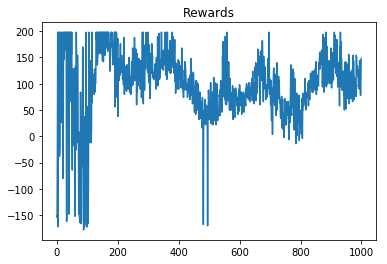

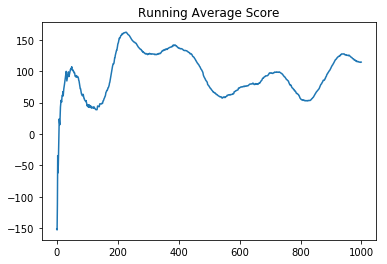

In [11]:
for i in range(N):
    eps = 1.0 / np.sqrt(i+1)
        
    total_r = play_one(model, eps, gamma)
    total_R[i] = total_r
    
    if i % 100 == 0:
         print('Episode: {} \tTotal Reward: {} \t Epsilon: {}'.format(i,
                                                                     total_r,
                                                                     eps))

print('Average reward for last 100 episodes: ', total_R[-100:].mean())
print('Total steps: ', total_R.sum())

plt.plot(total_R)
plt.title('Rewards')
plt.show()

plot_running_avg(total_R)